# Experiment with complete Lagrangian from exponentiated gradient as grid for grid search

In this, we compare time, violation and error from expgrad on full dataset, gridsearch on full dataset, hybrid model with various fractions of subsets.

### Notes:

1. For hybrid model, we report 2 values - expgrad on partial dataset and grid search by re-training all classifiers with output lagrangian of expgrad.

2. As predict may give variable results (due to randomisation), `_pmf_predict` is used to get the value of the `y_pred` for exp grad (in both cases - on partial and also on full dataset).

3. [Not used] Normalised values are calculated by: `({value}-{eps}) / {eps}` for violation and `({value}-{expgrad on full dataset})/{expgrad on full dataset}` for error.


In [1]:
!pip install fairlearn

     |████████████████████████████████| 21.2MB 1.6MB/s 


In [2]:
!pip install tempeh

     |████████████████████████████████| 276kB 8.3MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=df7680fa2711be3c9ff35b023d06de6900f3fb20577c480f346034ed9865be97
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394105 sha256=7c7dde8c9b5965b41e4b2fbe7ed88bba971de5a72fb8d76633466d40c1c5dd1b
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built memory-profiler shap


In [0]:
# load data
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML
import statistics 
import scipy.stats as st
from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tempeh.configurations import datasets

compas_dataset = datasets['compas']()
X_train_all, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train_all, y_test = compas_dataset.get_y(format=pd.Series)
A_train_all, A_test = compas_dataset.get_sensitive_features('race', format=pd.Series)

train_all = pd.concat([X_train_all, y_train_all, A_train_all], axis=1)

In [0]:
# Subsampling process
num_samples = 20
#fractions = [0.1, 0.5]
fractions = np.logspace(-2, 0, num=20)
eps = 0.05

In [5]:
#Unmitigated LogRes
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate
import numpy as np

In [7]:
# Error & Violation of unmitigated estimator
def UnmitLogistic(X): return logistic_learner.predict(X)
# violation
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
log_violation_unmitigated = disparity_moment.gamma(UnmitLogistic).max()

# error
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_unmitigated = error.gamma(UnmitLogistic)[0]
print('Logistic Regression - Violation: {}, Error: {}'.format(
    log_violation_unmitigated, log_error_unmitigated))

Logistic Regression - Violation: 0.15129907254478464, Error: 0.33455882352941174


In [8]:
# Expgrad on full dataset
expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(), eps=eps, nu=1e-6)

a=datetime.now()
expgrad_X_logistic.fit(X_train_all, y_train_all,
                       sensitive_features=A_train_all)
b=datetime.now()
time_expgrad_all = (b-a).seconds

def Qexp_all(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all,
                sensitive_features=A_train_all)
error_expgrad_all = error.gamma(Qexp_all)[0]

print('Exponentiated gradient on full dataset : Time: {} seconds; Violation: {}; Errror: {}'.format(
    time_expgrad_all, violation_expgrad_all, error_expgrad_all))

Exponentiated gradient on full dataset : Time: 7 seconds; Violation: 0.05000000000000043; Errror: 0.391800773607157


## Experiment 1: Hybrid 1

### Notes:

1. For grid search in hybrid model, we get `y_pred` using the best classifier out of all the predictors.

In [0]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [0]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import logging
import numpy as np
import pandas as pd
import pickle
import scipy.optimize as opt
from sklearn.dummy import DummyClassifier
from time import time

_PRECISION = 1e-8
_LINE = "_" * 9
_INDENTATION = " " * 9

logger = logging.getLogger(__name__)


class _Lagrangian:
    """Operations related to the Lagrangian.

    :param X: the training features
    :type X: Array
    :param sensitive_features: the sensitive features to use for constraints
    :type sensitive_features: Array
    :param y: the training labels
    :type y: Array
    :param estimator: the estimator to fit in every iteration of best_h
    :type estimator: an estimator that has a `fit` method with arguments X, y, and sample_weight
    :param constraints: Object describing the parity constraints. This provides the reweighting
        and relabelling
    :type constraints: `fairlearn.reductions.Moment`
    :param eps: allowed constraint violation
    :type eps: float
    :param B:
    :type B:
    :param opt_lambda: indicates whether to optimize lambda during the calculation of the
        Lagrangian; optional with default value True
    :type opt_lambda: bool
    """

    def __init__(self, X, sensitive_features, y, estimator, constraints, eps, B, opt_lambda=True):
        self.X = X
        self.constraints = constraints
        self.constraints.load_data(X, y, sensitive_features=sensitive_features)
        self.obj = self.constraints.default_objective()
        self.obj.load_data(X, y, sensitive_features=sensitive_features)
        self.pickled_estimator = pickle.dumps(estimator)
        self.eps = eps
        self.B = B
        self.opt_lambda = opt_lambda
        self.hs = pd.Series(dtype="float64")
        self.classifiers = pd.Series(dtype="float64")
        self.errors = pd.Series(dtype="float64")
        self.gammas = pd.DataFrame()
        self.lambdas = pd.DataFrame()
        self.n = self.X.shape[0]
        self.n_oracle_calls = 0
        self.n_oracle_calls_dummy_returned = 0
        self.oracle_execution_times = []
        self.last_linprog_n_hs = 0
        self.last_linprog_result = None

    def _eval(self, Q, lambda_vec):
        """Return the value of the Lagrangian.

        :param Q: `Q` is either a series of weights summing up to 1 that indicate the weight of
            each `h` in contributing to the randomized classifier, or a callable corresponding to
            a deterministic predict function.
        :type Q: pandas.Series or callable
        :param lambda_vec: lambda vector
        :type lambda_vec: pandas.Series

        :return: tuple `(L, L_high, gamma, error)` where `L` is the value of the Lagrangian,
            `L_high` is the value of the Lagrangian under the best response of the lambda player,
            `gamma` is the vector of constraint violations, and `error` is the empirical error
        """
        if callable(Q):
            error = self.obj.gamma(Q)[0]
            gamma = self.constraints.gamma(Q)
        else:
            error = self.errors[Q.index].dot(Q)
            gamma = self.gammas[Q.index].dot(Q)

        if self.opt_lambda:
            lambda_projected = self.constraints.project_lambda(lambda_vec)
            L = error + np.sum(lambda_projected * gamma) - self.eps * np.sum(lambda_projected)
        else:
            L = error + np.sum(lambda_vec * gamma) - self.eps * np.sum(lambda_vec)

        max_gamma = gamma.max()
        if max_gamma < self.eps:
            L_high = error
        else:
            L_high = error + self.B * (max_gamma - self.eps)
        return L, L_high, gamma, error

    def eval_gap(self, Q, lambda_hat, nu):
        r"""Return the duality gap object for the given :math:`Q` and :math:`\hat{\lambda}`."""
        L, L_high, gamma, error = self._eval(Q, lambda_hat)
        result = _GapResult(L, L, L_high, gamma, error)
        for mul in [1.0, 2.0, 5.0, 10.0]:
            h_hat, h_hat_idx = self.best_h(mul * lambda_hat)
            logger.debug("%smul=%.0f", _INDENTATION, mul)
            L_low_mul, _, _, _ = self._eval(pd.Series({h_hat_idx: 1.0}), lambda_hat)
            if L_low_mul < result.L_low:
                result.L_low = L_low_mul
            if result.gap() > nu + _PRECISION:
                break
        return result

    def solve_linprog(self, errors=None, gammas=None, nu=1e-6):
        if errors is None:
          errors = self.errors
        if gammas is None:
          gammas = self.gammas
        n_hs = len(self.hs)
        n_constraints = len(self.constraints.index)
        if self.last_linprog_n_hs == n_hs:
            return self.last_linprog_result
        c = np.concatenate((errors, [self.B]))
        A_ub = np.concatenate((gammas - self.eps, -np.ones((n_constraints, 1))), axis=1)
        b_ub = np.zeros(n_constraints)
        A_eq = np.concatenate((np.ones((1, n_hs)), np.zeros((1, 1))), axis=1)
        b_eq = np.ones(1)
        result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method='simplex')
        Q = pd.Series(result.x[:-1], self.hs.index)
        dual_c = np.concatenate((b_ub, -b_eq))
        dual_A_ub = np.concatenate((-A_ub.transpose(), A_eq.transpose()), axis=1)
        dual_b_ub = c
        dual_bounds = [(None, None) if i == n_constraints else (0, None) for i in range(n_constraints + 1)]  # noqa: E501
        result_dual = opt.linprog(dual_c,
                                  A_ub=dual_A_ub,
                                  b_ub=dual_b_ub,
                                  bounds=dual_bounds,
                                  method='simplex')
        lambda_vec = pd.Series(result_dual.x[:-1], self.constraints.index)
        self.last_linprog_n_hs = n_hs
        self.last_linprog_result = (Q, lambda_vec, self.eval_gap(Q, lambda_vec, nu))
        return self.last_linprog_result

    def _call_oracle(self, lambda_vec):
        signed_weights = self.obj.signed_weights() + self.constraints.signed_weights(lambda_vec)
        redY = 1 * (signed_weights > 0)
        redW = signed_weights.abs()
        redW = self.n * redW / redW.sum()

        redY_unique = np.unique(redY)

        classifier = None
        if len(redY_unique) == 1:
            logger.debug("redY had single value. Using DummyClassifier")
            classifier = DummyClassifier(strategy='constant',
                                         constant=redY_unique[0])
            self.n_oracle_calls_dummy_returned += 1
        else:
            classifier = pickle.loads(self.pickled_estimator)

        oracle_call_start_time = time()
        classifier.fit(self.X, redY, sample_weight=redW)
        self.oracle_execution_times.append(time() - oracle_call_start_time)
        self.n_oracle_calls += 1

        return classifier

    def best_h(self, lambda_vec):
        """Solve the best-response problem.

        Returns the classifier that solves the best-response problem for
        the vector of Lagrange multipliers `lambda_vec`.
        """
        classifier = self._call_oracle(lambda_vec)
        def h(X): return classifier.predict(X)
        h_error = self.obj.gamma(h)[0]
        h_gamma = self.constraints.gamma(h)
        h_value = h_error + h_gamma.dot(lambda_vec)

        if not self.hs.empty:
            values = self.errors + self.gammas.transpose().dot(lambda_vec)
            best_idx = values.idxmin()
            best_value = values[best_idx]
        else:
            best_idx = -1
            best_value = np.PINF

        if h_value < best_value - _PRECISION:
            logger.debug("%sbest_h: val improvement %f", _LINE, best_value - h_value)
            h_idx = len(self.hs)
            self.hs.at[h_idx] = h
            self.classifiers.at[h_idx] = classifier
            self.errors.at[h_idx] = h_error
            self.gammas[h_idx] = h_gamma
            self.lambdas[h_idx] = lambda_vec.copy()
            best_idx = h_idx

        return self.hs[best_idx], best_idx


class _GapResult:
    """The result of a duality gap computation."""

    def __init__(self, L, L_low, L_high, gamma, error):
        self.L = L
        self.L_low = L_low
        self.L_high = L_high
        self.gamma = gamma
        self.error = error

    def gap(self):
        return max(self.L - self.L_low, self.L_high - self.L)


In [0]:
def solve_linprog(errors=None, gammas=None, eps=0.05, nu=1e-6, pred=None):
    B = 1/eps
    n_hs = len(pred)
    n_constraints = 4 #len()

    c = np.concatenate((errors, [B]))
    A_ub = np.concatenate((gammas - eps, -np.ones((n_constraints, 1))), axis=1)
    b_ub = np.zeros(n_constraints)
    A_eq = np.concatenate((np.ones((1, n_hs)), np.zeros((1, 1))), axis=1)
    b_eq = np.ones(1)
    result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method='simplex')
    Q = pd.Series(result.x[:-1])
    return Q

In [0]:
# hybrid model

# Variables
time_expgrad_fracs = []
time_hybrids = []
time_expgrad_alls = []

error_expgrad_fracs = []
error_hybrids = []
error_expgrad_alls = []

vio_expgrad_fracs = []
vio_hybrids = []
vio_expgrad_alls = []


error_expgrad_fracs_std = []
error_hybrids_std = []

vio_expgrad_fracs_std = []
vio_hybrids_std = []

# Hybrid 2
error_grid_pmf_fracs = []
vio_grid_pmf_fracs = []

error_grid_pmf_fracs_std = []
vio_grid_pmf_fracs_std = []

# Hybrid 3
vio_rewts_pmf = []
error_rewts_pmf = []

vio_rewts_pmf_std = []
error_rewts_pmf_std = []


# Hybrid 0
# error_best_lambdas = []
# vio_best_lambdas = []

# Hybrid 4
vio_rewts_partial = []
error_rewts_partial = []

# Hybrid 5
vio_no_grid_rewts = []
error_no_grid_rewts = []


# eval_gap_mean = []
# eval_gap_std = []
# eval_gap_max = []
B = 1 / eps

# Iterations on difference fractions
for i,f in enumerate(fractions):
    time_expgrad_alls.append(time_expgrad_all)
    error_expgrad_alls.append(error_expgrad_all)
    vio_expgrad_alls.append(violation_expgrad_all)
    
    _time_expgrad_fracs = []
    _time_grid_fracs = []
    _time_hybrids = []

    _error_expgrad_fracs = []
    _error_hybrids = []
    _error_grid_pmf_fracs = []
    _error_rewts = []

    _vio_expgrad_fracs = []
    _vio_hybrids = []
    _vio_grid_pmf_fracs = []
    _vio_rewts = []

    _vio_rewts_partial = []
    _error_rewts_partial = []

    _vio_no_grid_rewts = []
    _error_no_grid_rewts = []

    # _best_lambda = pd.DataFrame()

    for n in range(num_samples):
        # get samples
        subsampling = train_all.sample(frac=f, random_state=n+20)
        subsampling = subsampling.reset_index()
        subsampling = subsampling.drop(columns=['index'])
        tmp = subsampling.iloc[:, :-1]
        A_train = subsampling.iloc[:, -1]
        X_train = tmp.iloc[:, :-1]
        y_train = tmp.iloc[:,-1]

        # Expgrad on sub dataset
        expgrad_X_logistic_frac = ExponentiatedGradient(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), eps=eps, nu=1e-6)

        a=datetime.now()  
        expgrad_X_logistic_frac.fit(X_train, y_train, sensitive_features=A_train)
        b=datetime.now()
        time_expgrad_frac = (b-a).seconds
        _time_expgrad_fracs.append(time_expgrad_frac)

        def Qexp(X): return expgrad_X_logistic_frac._pmf_predict(X)[:, 1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all,
                                   sensitive_features=A_train_all)
        violation_expgrad_logistic_frac = disparity_moment.gamma(Qexp).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all,
                        sensitive_features=A_train_all)
        error_expgrad_logistic_frac = error.gamma(Qexp)[0]

        _error_expgrad_fracs.append(error_expgrad_logistic_frac)
        _vio_expgrad_fracs.append(violation_expgrad_logistic_frac)

        # Hybrid 5: run LP with full dataset on predictors trained on partial dataset only
        no_grid_errors = []
        no_grid_vio = pd.DataFrame()
        expgrad_predictors = expgrad_X_logistic_frac._predictors
        for x in range(len(expgrad_predictors)):
          def Q_preds_no_grid(X): return expgrad_predictors[x].predict(X)
          # violation of log res
          disparity_moment = DemographicParity()
          disparity_moment.load_data(X_train_all, y_train_all,
                                    sensitive_features=A_train_all)
          violation_no_grid_frac = disparity_moment.gamma(Q_preds_no_grid)

          # error of log res
          error = ErrorRate()
          error.load_data(X_train_all, y_train_all,
                          sensitive_features=A_train_all)
          error_no_grid_frac = error.gamma(Q_preds_no_grid)['all']

          no_grid_vio[x] = violation_no_grid_frac
          no_grid_errors.append(error_no_grid_frac)

        no_grid_errors = pd.Series(no_grid_errors)
        new_weights_no_grid = solve_linprog(errors=no_grid_errors, gammas=no_grid_vio, eps=0.05, nu=1e-6, pred=expgrad_predictors)
        def Q_rewts_no_grid(X): return _pmf_predict(X, expgrad_predictors, new_weights_no_grid)[:,1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        vio_rewts_no_grid_ = disparity_moment.gamma(Q_rewts_no_grid).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        error_rewts_no_grid_ = error.gamma(Q_rewts_no_grid)[0]

        _vio_no_grid_rewts.append(vio_rewts_no_grid_)
        _error_no_grid_rewts.append(error_rewts_no_grid_)


        # Grid Search part
        lambda_vecs_logistic = expgrad_X_logistic_frac._lambda_vecs_lagrangian
        grid_search_logistic_frac = GridSearch(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), grid=lambda_vecs_logistic)
        a=datetime.now()
        grid_search_logistic_frac.fit(X_train_all, y_train_all,
                                      sensitive_features=A_train_all)
        b=datetime.now()
        time_grid_frac = (b-a).seconds
        _time_grid_fracs.append(time_grid_frac)
        _time_hybrids.append(time_grid_frac + time_expgrad_frac)

        def Qgrid(X): return grid_search_logistic_frac.predict(X)
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all,
                                   sensitive_features=A_train_all)
        violation_grid_frac = disparity_moment.gamma(Qgrid).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all,
                        sensitive_features=A_train_all)
        error_grid_frac = error.gamma(Qgrid)['all']

        _vio_hybrids.append(violation_grid_frac)
        _error_hybrids.append(error_grid_frac)


        # Hybrid 2: pmf_predict with exp grad weights in grid search
        _weights_logistic = expgrad_X_logistic_frac._weights
        _predictors = grid_search_logistic_frac._predictors

        def Qlog(X): return _pmf_predict(X, _predictors, _weights_logistic)[:,1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        violation_grid_search_pmf = disparity_moment.gamma(Qlog).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        error_grid_search_pmf = error.gamma(Qlog)[0]

        _vio_grid_pmf_fracs.append(violation_grid_search_pmf)
        _error_grid_pmf_fracs.append(error_grid_search_pmf)

        # Hybrid 0: grid of best lambdas of each subset
        # lambda_vecs = expgrad_X_logistic_frac._lambda_vecs_LP
        # keys = lambda_vecs.keys()
        # _best_lambda[n] = lambda_vecs[keys[-1]]

        #Hybrid 3: re-weight using LP
        grid_errors = []
        grid_vio = pd.DataFrame()
        for x in range(len(_predictors)):
          def Q_preds(X): return _predictors[x].predict(X)
          # violation of log res
          disparity_moment = DemographicParity()
          disparity_moment.load_data(X_train_all, y_train_all,
                                    sensitive_features=A_train_all)
          violation_grid_frac = disparity_moment.gamma(Q_preds)

          # error of log res
          error = ErrorRate()
          error.load_data(X_train_all, y_train_all,
                          sensitive_features=A_train_all)
          error_grid_frac = error.gamma(Q_preds)['all']

          grid_vio[x] = violation_grid_frac
          grid_errors.append(error_grid_frac)

        grid_errors = pd.Series(grid_errors)
        new_weights = solve_linprog(errors=grid_errors, gammas=grid_vio, eps=0.05, nu=1e-6, pred=_predictors)
        def Q_rewts(X): return _pmf_predict(X, _predictors, new_weights)[:,1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        vio_rewts_pmf_ = disparity_moment.gamma(Q_rewts).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        error_rewts_pmf_ = error.gamma(Q_rewts)[0]

        _vio_rewts.append(vio_rewts_pmf_)
        _error_rewts.append(error_rewts_pmf_)


        # Hybrid 4: re-weight only the non-zero weight predictors using LP
        re_wts_predictors = []
        for x in  range(len(_weights_logistic)):
          if _weights_logistic[x] != 0:
            re_wts_predictors.append(_predictors[x])
        grid_errors_partial = []
        grid_vio_partial = pd.DataFrame()
        for x in range(len(re_wts_predictors)):
          def Q_preds_partial(X): return re_wts_predictors[x].predict(X)
          # violation of log res
          disparity_moment = DemographicParity()
          disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
          violation_grid_frac_partial = disparity_moment.gamma(Q_preds_partial)

          # error of log res
          error = ErrorRate()
          error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
          error_grid_frac_partial = error.gamma(Q_preds_partial)['all']

          grid_vio_partial[x] = violation_grid_frac_partial
          grid_errors_partial.append(error_grid_frac_partial)

        grid_errors_partial = pd.Series(grid_errors_partial)
        new_weights_partial = solve_linprog(errors=grid_errors_partial, gammas=grid_vio_partial, eps=0.05, nu=1e-6, pred=re_wts_predictors)
        def Q_rewts_partial(X): return _pmf_predict(X, re_wts_predictors, new_weights_partial)[:,1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        vio_rewts_partial_ = disparity_moment.gamma(Q_rewts_partial).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        error_rewts_partial_ = error.gamma(Q_rewts_partial)[0]

        _vio_rewts_partial.append(vio_rewts_partial_)
        _error_rewts_partial.append(error_rewts_partial_)

    time_expgrad_fracs.append(np.mean(_time_expgrad_fracs))
    time_hybrids.append(np.mean(_time_hybrids))

    # exp frac
    error_expgrad_fracs.append(np.mean(_error_expgrad_fracs))
    vio_expgrad_fracs.append(np.mean(_vio_expgrad_fracs))

    error_expgrad_fracs_std.append(statistics.stdev(_error_expgrad_fracs))
    vio_expgrad_fracs_std.append(statistics.stdev(_vio_expgrad_fracs))

    # Hybrid 1
    error_hybrids.append(np.mean(_error_hybrids))
    vio_hybrids.append(np.mean(_vio_hybrids))

    error_hybrids_std.append(statistics.stdev(_error_hybrids))
    vio_hybrids_std.append(statistics.stdev(_vio_hybrids))

    # Hybrid 2
    vio_grid_pmf_fracs.append(np.mean(_vio_grid_pmf_fracs))
    error_grid_pmf_fracs.append(np.mean(_error_grid_pmf_fracs))
    
    error_grid_pmf_fracs_std.append(statistics.stdev(_error_grid_pmf_fracs))
    vio_grid_pmf_fracs_std.append(statistics.stdev(_vio_grid_pmf_fracs))

    # Hybrid 3: re-weight using LP
    vio_rewts_pmf.append(np.mean(_vio_rewts))
    error_rewts_pmf.append(np.mean(_error_rewts))
    
    vio_rewts_pmf_std.append(statistics.stdev(_error_rewts))
    error_rewts_pmf_std.append(statistics.stdev(_vio_rewts))

    # Hybrid 0: grid of best lambdas of each subset
    # grid_search_best_lambdas = GridSearch(
    #         LogisticRegression(solver='liblinear', fit_intercept=True),
    #         constraints=DemographicParity(), grid=_best_lambda)
    # grid_search_best_lambdas.fit(X_train_all, y_train_all,
    #                                   sensitive_features=A_train_all)
    
    # def Qgrid(X): return grid_search_best_lambdas.predict(X)
    # # violation of log res
    # disparity_moment = DemographicParity()
    # disparity_moment.load_data(X_train_all, y_train_all,
    #                             sensitive_features=A_train_all)
    # vio_lambda = disparity_moment.gamma(Qgrid).max()

    # # error of log res
    # error = ErrorRate()
    # error.load_data(X_train_all, y_train_all,
    #                 sensitive_features=A_train_all)
    # error_lambda = error.gamma(Qgrid)['all']

    # vio_best_lambdas.append(vio_lambda)
    # error_best_lambdas.append(error_lambda)

    # predictors_best_lambda = grid_search_best_lambdas._predictors
    # result_gap = []
    # for i in range(len(predictors_best_lambda)):
    #   def Q(X): return predictors_best_lambda[i].predict(X)
    #   lagrangian = _Lagrangian(X_train_all, A_train_all, y_train_all,
    #                            predictors_best_lambda[i],
    #                            DemographicParity(), eps, B)
    #   res = lagrangian.eval_gap(Q, _best_lambda[i], nu=1e-6)
    #   result_gap.append(res.gap())

    # Hybrid 4
    vio_rewts_partial.append(np.mean(_vio_rewts_partial))
    error_rewts_partial.append(np.mean(_error_rewts_partial))
    

    # Hybrid 5
    vio_no_grid_rewts.append(np.mean(_vio_no_grid_rewts))
    error_no_grid_rewts.append(np.mean(_error_no_grid_rewts))
      
    # eval gap mean and std
    # eval_gap_mean.append(np.mean(result_gap))
    # eval_gap_max.append(np.max(result_gap))
    # eval_gap_std.append(statistics.stdev(result_gap))



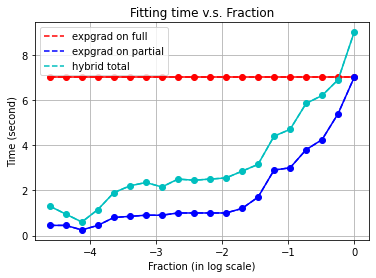

In [13]:
# Print Time and plot them
fr = np.log(fractions) 

import matplotlib.pyplot as plt

l1 = plt.plot(fr, time_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fr, time_expgrad_fracs,'b--',label="expgrad on partial")
l3 = plt.plot(fr, time_hybrids,'c--',label="hybrid total")
plt.plot(fr, time_expgrad_alls,'ro-',
         fr, time_expgrad_fracs,'bo-', fr, time_hybrids,'co-')
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Time (second)')
plt.title('Fitting time v.s. Fraction')
plt.grid()
plt.legend()
plt.show()



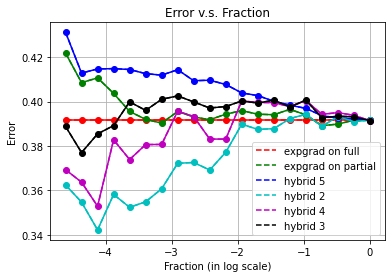

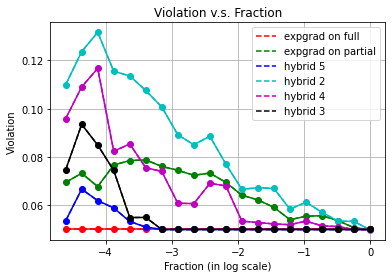

In [14]:
import matplotlib.pyplot as plt

l1 = plt.plot(fr, error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fr, error_expgrad_fracs,'g--',label="expgrad on partial")
l3 = plt.plot(fr, error_no_grid_rewts,'b--',label="hybrid 5")
l4 = plt.plot(fr, error_grid_pmf_fracs,'c--',label="hybrid 2")
l5 = plt.plot(fr, error_rewts_partial,'m--',label="hybrid 4")
l6 = plt.plot(fr, error_rewts_pmf,'k--',label="hybrid 3")
plt.plot(fr, error_expgrad_alls,'ro-', fr, error_expgrad_fracs,'go-',
         fr, error_no_grid_rewts,'bo-', fr, error_grid_pmf_fracs,'co-',
         fr, error_rewts_partial,'mo-', fr, error_rewts_pmf,'ko-'
         )
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

l1 = plt.plot(fr, vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fr, vio_expgrad_fracs,'g--',label="expgrad on partial")
l3 = plt.plot(fr, vio_no_grid_rewts,'b--',label="hybrid 5")
l4 = plt.plot(fr, vio_grid_pmf_fracs,'c--',label="hybrid 2")
l5 = plt.plot(fr, vio_rewts_partial,'m--',label="hybrid 4")
l6 = plt.plot(fr, vio_rewts_pmf,'k--',label="hybrid 3")
plt.plot(fr, vio_expgrad_alls,'ro-', fr, vio_expgrad_fracs,'go-',
         fr, vio_no_grid_rewts,'bo-', fr, vio_grid_pmf_fracs,'co-',
         fr, vio_rewts_partial,'mo-', fr, vio_rewts_pmf,'ko-'
         )
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()

In [0]:
# # error bars of result of various subsamples per fraction
# plt.errorbar(fr, vio_hybrids, np.multiply(vio_hybrids_std, 2), linestyle='',color='b', label="hybrid 1")
# plt.errorbar(fr, vio_grid_pmf_fracs, np.multiply(vio_grid_pmf_fracs_std, 2), linestyle='', color='c', label="hybrid 2")
# plt.xlabel('Fraction (in log scale)')
# plt.ylabel('Violation')
# plt.title('Violation v.s. Fraction -- Error bars')
# plt.grid()
# plt.legend()
# plt.show()

# plt.errorbar(fr, error_hybrids, np.multiply(error_hybrids_std, 2), linestyle='',color='b', label="hybrid 1")
# plt.errorbar(fr, error_grid_pmf_fracs, np.multiply(error_grid_pmf_fracs_std, 2), linestyle='', color='c', label="hybrid 2")
# plt.xlabel('Fraction (in log scale)')
# plt.ylabel('Error')
# plt.title('Error v.s. Fraction -- Error bars')
# plt.grid()
# plt.legend()
# plt.show()


In [0]:
# import math

# # Print Error and plot them
# print('Model\t\t\tError')
# print('{}\t{}'.format('Exp.Grad. on full', error_expgrad_alls[0]))
# #print('{}\t{}'.format('Grid Search on full', error_grid_alls[0]))
# print('---------------------------------------------')
# print('- \t\t Hybrid 1 \t\t Hybrid 2 \t\t Hybrid 0 \t\t Hybrid 3')
# print('Fraction\tError \tVio\t\tError\tVio\t\tError \tVio\t\tError\tVio')

# for i in range(len(fractions)):
#     print('{}\t\t{}\t{}\t\t{}\t{}\t\t{}\t{}\t\t{}\t{}'.format(round(fractions[i], 5),
#                                           round(error_hybrids[i],5), round(error_hybrids[i],5), 
#                                           round(error_grid_pmf_fracs[i],5), round(vio_grid_pmf_fracs[i],5),
#                                           round(error_best_lambdas[i],5), round(vio_best_lambdas[i],5),
#                                           round(error_rewts_pmf[i],5), round(vio_rewts_pmf[i],5)))


In [0]:
# plt.errorbar(fr, eval_gap_mean, np.multiply(eval_gap_std, 2), color='b', label="Eval gap")
# plt.xlabel('Fraction (in log scale)')
# plt.ylabel('Eval Gap from various subsets')
# plt.title('Eval gap v.s. Fraction -- Error bars')
# plt.grid()
# plt.legend()
# plt.show()


In [0]:
# plt.plot(fr, eval_gap_max, color='b', label="Max Eval Gap")
# plt.xlabel('Fraction (in log scale)')
# plt.ylabel('Eval Gap from various subsets')
# plt.title('Eval gap v.s. Fraction -- Error bars')
# plt.grid()
# plt.legend()
# plt.show()
